In [36]:
from matplotlib import pyplot as plt
from ipywidgets import interactive

plt.rcParams['figure.figsize'] = (17, 10)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.solid_capstyle'] = 'round'

In [37]:
import numpy as np
import cft
from adhesion import get_convex_hull, plot_regular_triangulation, plot_power_diagram, plot_image

xlim = None
ylim = None

## A universe in a box

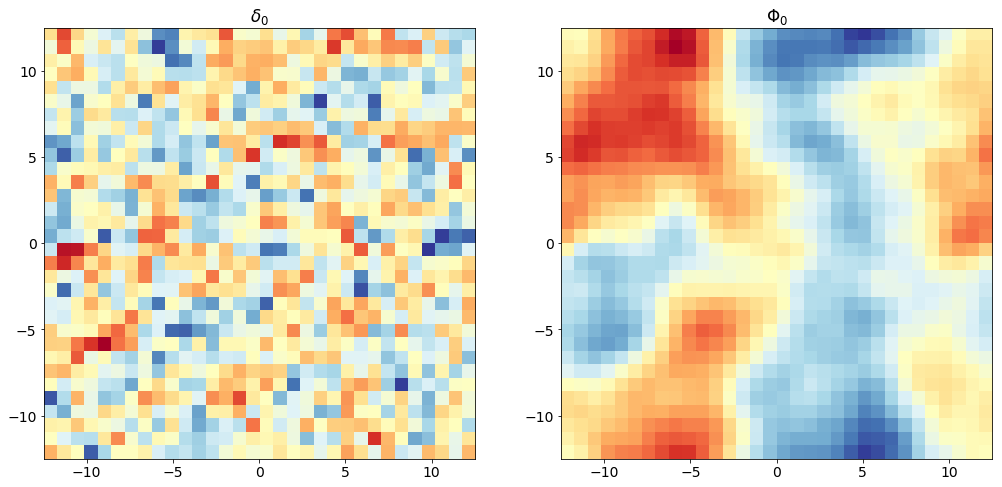

In [38]:
# Create a box
box = cft.Box(dim=2, N=32, L=25.)

def get_potential(n_P):
    # Specify the power spectrum
    P = cft.Power_law(n=n_P) * cft.Scale(box, 0.5)

    # Create initial density perturbations
    delta_0 = cft.garfield(B=box, P=P, seed=420)

    # Normalize (typical collapse time at D=1)
    delta_0 /= delta_0.std()

    # Compute the potential
    pot_0 = np.fft.ifftn(np.fft.fftn(delta_0) * cft.Potential()(box.K)).real
    
    return delta_0, pot_0

delta_0, pot_0 = get_potential(-0.5)
fig, axes = plt.subplots(1, 2)
plot_image(box, delta_0, title='$\delta_0$', ax=axes[0])
plot_image(box, pot_0, title='$\Phi_0$', ax=axes[1])
plt.show()

## Lifting vertices

\begin{equation}
v_i = \begin{pmatrix} x({\bf q}_i) \\ y({\bf q}_i) \\ \vdots \\ {\bf q}_i^2 - 2 D \Phi({\bf q}_i) \end{pmatrix}
\end{equation}

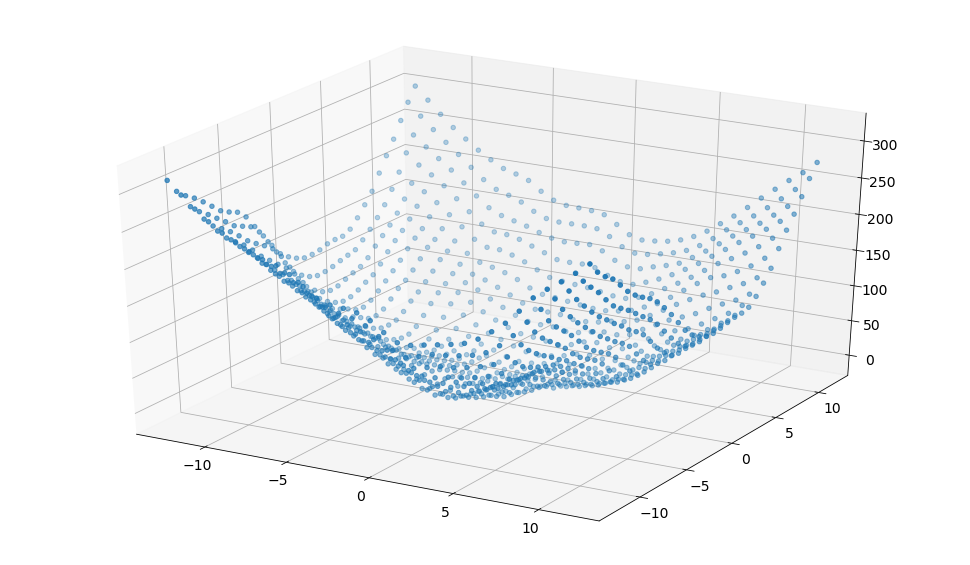

In [44]:
def lagrangian_vertices(box, pot, D):
    """Get a grid of vertices as described in `box` and lift them to the
    given potential `pot` at time `t`."""
    q = np.indices(box.shape) * box.L/box.N - box.L/2
    z = np.sum(q**2, axis=0) - 2 * D * pot
    return np.concatenate([q, np.expand_dims(z, 0)], 0).reshape(box.dim+1, -1).T

v = lagrangian_vertices(box, pot_0, 5.0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v[:, 0], v[:, 1], v[:, 2])
plt.show()

## All ye structures

In [39]:
def plot_dual(t, n_P):
    density_0, pot_0 = get_potential(n_P)
    
    # Get the Convex Hull
    ch, selection, valid = get_convex_hull(box, pot_0, t)
    
    # Plot the result
    fig, axes = plt.subplots(1, 2, subplot_kw={'aspect': 1})
    plot_regular_triangulation(ch, selection, xlim, ylim, ax=axes[0])
    plot_power_diagram(box, ch, valid, xlim, ylim, point_scale=10, ax=axes[1])
    plt.show()

In [40]:
interactive_plot = interactive(
    plot_dual, t=(0.0, 5.0, 0.1), n_P=(-2.0, 4.0, 0.25))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot.children[0].description = 'D'
interactive_plot

interactive(children=(FloatSlider(value=2.5, description='D', max=5.0), FloatSlider(value=1.0, description='n_…